# Robustness to Sensor Error

We will discuss methods for enhancing the robustness of autonomous systems to sensor error.

Reading: DMU 4.1, 4.2, 4.7

Assignment: Enhance your collision avoidance system to accommodate sensor error and run it in simulation.

## What is a Sensor

- we had uncertainty in initial conditions
- we had uncertainty in transition
- sensors add uncertainty to your observation, and thus contribute to _state uncertainty_

![Uncertainty](figures/decision_theoretic_planning.png)

## Types of Sensors

Sensors on your phone
- Accelerometers measure acceleration
- Gyroscopes measure angular rate
- Cameras measure light intensity in different wavelengths (they take photos)
- GPS measures your position

Sensors on autonomous cars
- Lidar obtains point clouds of the surrounding environment
- Radar obtains range rate of surrounding metal objects
- Odometry obtains precise wheel rates and positions

Sensors on planes
- Pitot-static tube measures fluid flow velocity
- IMU measures position and orientation using a combination of sensors
- Transponders allow aircraft to share information

## Filtering

Most sensors are imperfect. Filtering is a means of keeping track of your best estimate of the true state, or a belief over the possible true states.

## Alpha-Beta Filter

The Alpha-Beta filter is a simple way to keep track of a noisy variable. It is easy to implement.

The Alpha-Beta filter models the tracked value using a position $x$ and a speed $v$. It has three paremeters, $\alpha$, $\beta$, and a timestep $\Delta t$.

In [9]:
mutable struct AlphaBetaFilter
    x::Float64 # "position" of tracked value
    v::Float64 # "speed" of tracked value
    α::Float64 # alpha parameter [0 < α < 1]
    β::Float64 # beta parameter [0 < β ≤ 2]
    dt::Float64 # timestep
end

Absent of observation, the tracked value is assumed to propagate with constant speed:

$$x' \leftarrow x + \Delta t \cdot v$$

We then receive an observation of the new state, $o$. The difference between the observation and the predicted value is the _residual_:

$$r \leftarrow o - x'$$

The filter then adjusts its prediction based on the residual. The parameters $\alpha$ and $\beta$ are tuned based on how much you trust your prediction versus how much you trust the observation.

$$x' \leftarrow x' + \alpha r$$

$$v' \leftarrow v + \frac{\beta}{\Delta t} r$$

In [10]:
function observe!(filter::AlphaBetaFilter, o::Float64)
    x, v, α, β, dt = filter.x, filter.v, filter.α, filter.β, filter.dt
    
    xp = x + dt*v   # predict based on constant speed
    r = o - xp      # compute residual
    xp = xp + α*r   # update position estimate
    vp = v + β/dt*r # update speed estimate
    
    filter.x = xp   # store for later
    filter.v = vp
    filter
end

observe! (generic function with 1 method)

Now we apply the Alpha-Beta filter to tracking an undamped spring.
We observe it with random noise - $N(0,1/40)$.

The following displays the true circle alongside the noisy measurement.

In [23]:
using AA120Q, Reactive, Interact, Compose, Colors, Cairo

function animate(f, steps)
    ff = [f(i) for i in steps]
    @manipulate for i = 1:length(ff)
        ff[i]
    end
end

function drawspring(t)
    x = sin(t)/3+0.5
    o = x + randn()/40   
    c_true = compose(context(), Compose.circle(x, 0.5, 0.05), fill(colorant"black"))
    c_obs = compose(context(), Compose.circle(o, 0.5, 0.04), fill(colorant"gray"))
    compose(context(), c_obs, c_true)
end

animate(drawspring, 0:0.1:10)

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
51), Observable{Int64} with 2 listeners. Value:
51, Scope("knockout-component-59646c9e-a3c0-420e-bcd3-b9b81e26ad73", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>101,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":51}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-59646c9e-a3c0-420e-bcd3-b9b81e26ad73\",\"id\":\"ob_53\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-59646c9e-a3c0-420e-bcd3-b9b81e26ad73\",\"id\":\"ob_52\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"va

Here we show the true circle alongside the filtered location.

(Students! Suggest changes to the filter parameters to try to improve the filter behavior)

In [13]:
x = 0.5
v = 0.0
α = 0.5
β = 0.5
dt = 1/30
abfilter = AlphaBetaFilter(x, v, α, β, dt)

function drawspring(t, abfilter::AlphaBetaFilter)
    x = sin(t)/3+0.5
    o = x + randn()/40
    observe!(abfilter, o)
    
    c_true = compose(context(), Compose.circle(x, 0.5, 0.05), fill(colorant"black"))
    c_obs = compose(context(), Compose.circle(o, 0.5, 0.04), fill(colorant"gray"))
    c_filter = compose(context(), Compose.circle(abfilter.x, 0.5, 0.03), fill(colorant"blue"))
    compose(context(), c_filter, c_obs, c_true)
end

animate(t->drawspring(t, abfilter), 0:0.1:10)

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
51), Observable{Int64} with 2 listeners. Value:
51, Scope("knockout-component-9d5cc1b9-48ea-49f8-a001-f4ed314771cb", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>101,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":51}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-9d5cc1b9-48ea-49f8-a001-f4ed314771cb\",\"id\":\"ob_22\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-9d5cc1b9-48ea-49f8-a001-f4ed314771cb\",\"id\":\"ob_21\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"va

## Moving Average

Another simple technique for filtering is to take a moving average. Perhaps the easiest is take a linear combination between your current prediction and your next value. This is an exponential moving average.

$$x' \leftarrow \gamma o + (1-\gamma) x$$

In [14]:
mutable struct SimpleMovingAverager
    x::Float64
    γ::Float64
end
function observe!(filter::SimpleMovingAverager, o::Float64)
    x, γ = filter.x, filter.γ
    xp = γ*o + (1-γ)*x
    filter.x = xp
    filter
end

observe! (generic function with 2 methods)

In [15]:
γ = 0.5
γfilter = SimpleMovingAverager(0.5, γ)

function drawspring(t, γfilter::SimpleMovingAverager)
    x = sin(t)/3+0.5
    o = x + randn()/40
    observe!(γfilter, o)
    
    c_true = compose(context(), Compose.circle(x, 0.5, 0.05), fill(colorant"black"))
    c_obs = compose(context(), Compose.circle(o, 0.5, 0.04), fill(colorant"gray"))
    c_filter = compose(context(), Compose.circle(γfilter.x, 0.5, 0.03), fill(colorant"blue"))
    compose(context(), c_filter, c_obs, c_true)
end

animate(t->drawspring(t, γfilter), 0:0.1:10)

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:t=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
51,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"  …  "9.1", "9.2", "9.3", "9.4", "9.5", "9.6", "9.7", "9.8", "9.9", "10.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"5.0",:value=>Observable{Float64} with 2 listeners. Value:
5.0), Observable{Float64} with 2 listeners. Value:
5.0, Scope("knockout-component-abc77f76-d1b7-47cc-a6d6-f2efe0631d25", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>101,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"  …  "9.1", "9.2", "9.3", "9.4", "9.5", "9.6", "9.7", "9.8", "9.9", "10.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"5.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"0.0\\\",\\\"0.1\

## Noisy Mountain Car

We extend the Mountain Car example from last week with sensor uncertainty. The car now obtains an _observation_ at every frame which it uses to make its decision.

Let us assume that the car has an odometer, but it doesn't work so well. The observation is the true velocity plus zero-mean Gaussian noise:

$$o = v + \varepsilon = v + \mathcal{N}(\mu = 0, \sigma=\frac{1}{4})$$

The car doesn't have a GPS, so it doesn't get a position estimate.

In [16]:
include("mountaincar.jl")
observation(car::MountainCar) = car.v + randn()/4

observation (generic function with 1 method)

Here is what we get if we use the previous policy without filtering the observation.

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
51), Observable{Int64} with 2 listeners. Value:
51, Scope("knockout-component-7bcde53d-48c7-4d50-88cc-ece74b91ba4b", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>101,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":51}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-7bcde53d-48c7-4d50-88cc-ece74b91ba4b\",\"id\":\"ob_38\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-7bcde53d-48c7-4d50-88cc-ece74b91ba4b\",\"id\":\"ob_37\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"va
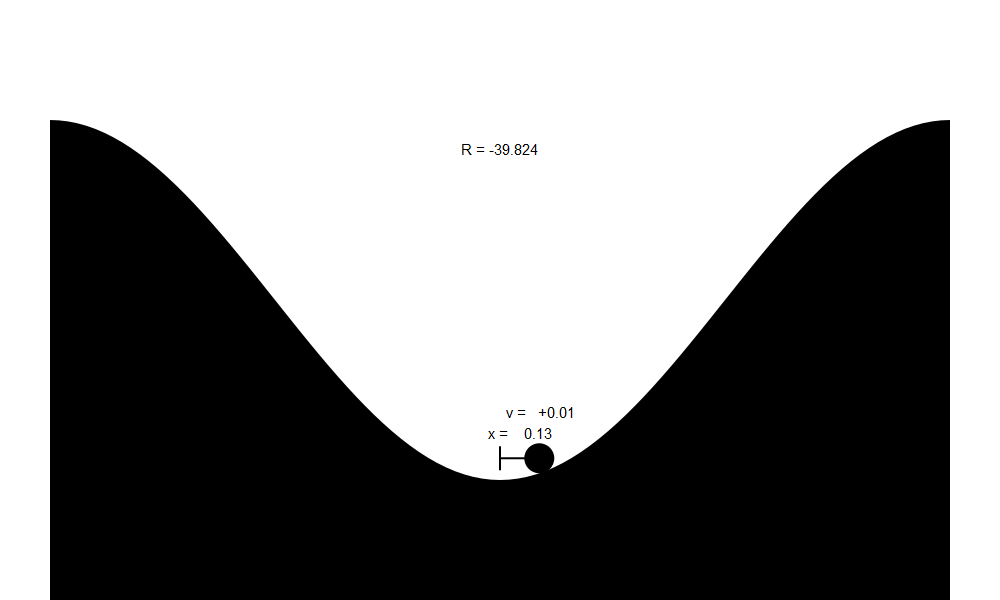
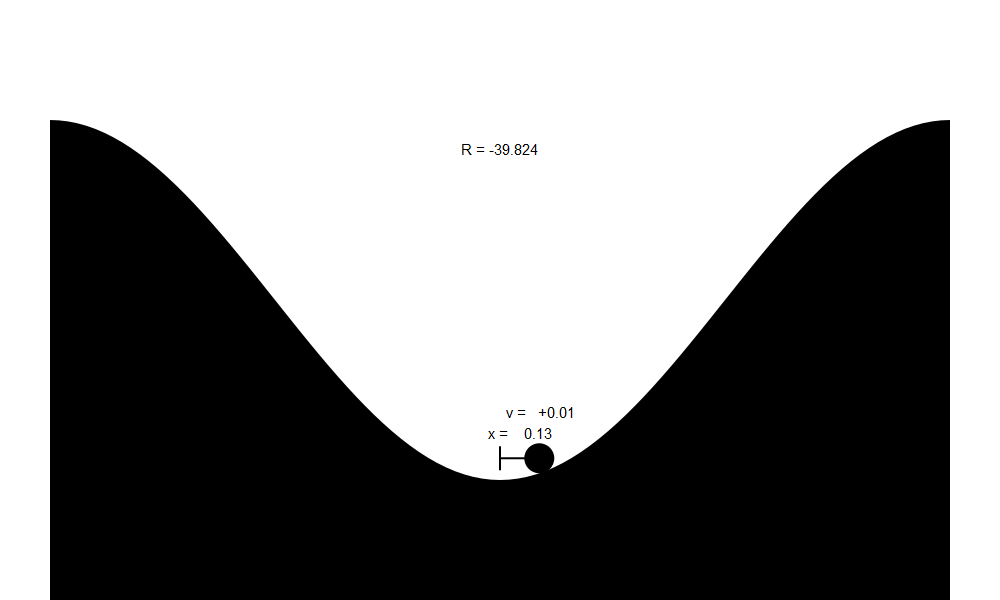

In [18]:
car = MountainCar(0.0,0.0)
R = 0.0
function tick!(Δt=1/60)
    global car
    o = observation(car)
    a = o > 0.0 ? :right : :left
    car = AA120Q.update!(car, a)
    global R = R*0.99 + reward(car, a)
    render_mountain_car(car, render_pos_overlay=true, reward=R)
end

animate(tick!, 0:0.1:10)

Let's run a few simulations and compute the mean reward over that time. This lets us estimate the policy performance.

In [19]:
function get_reward(nsteps::Int)
    car = MountainCar(0.0,0.0)
    R = 0.0
    for t in 1 : nsteps
        o = observation(car)
        a = o > 0.0 ? :right : :left # our policy
        car = AA120Q.update!(car, a)
        R += reward(car, a)
    end
    R
end

nsteps = 1000
nsimulations = 10
mean([get_reward(nsteps) for i in 1:nsimulations])

-636.7813353743097

Now here is the performance of a policy using an exponential moving average:

In [20]:
γ = 0.1
γfilter = SimpleMovingAverager(0.5, γ)

function get_reward(nsteps::Int, γfilter::SimpleMovingAverager)
    car = MountainCar(0.0,0.0)
    R = 0.0
    for t in 1 : nsteps
        o = observation(car)
        observe!(γfilter, o)
        a = γfilter.x > 0.0 ? :right : :left
        car = AA120Q.update!(car, a)
        R += reward(car, a)
    end
    R
end

nsteps = 1000
nsimulations = 10
mean([get_reward(nsteps, γfilter) for i in 1:nsimulations])

563.7453240957489

That is a _huge_ difference!

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
101), Observable{Int64} with 2 listeners. Value:
101, Scope("knockout-component-51eb7e47-4e60-4c9e-8fe9-f1ac456de531", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>201,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
101, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":101}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-51eb7e47-4e60-4c9e-8fe9-f1ac456de531\",\"id\":\"ob_48\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-51eb7e47-4e60-4c9e-8fe9-f1ac456de531\",\"id\":\"ob_47\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[
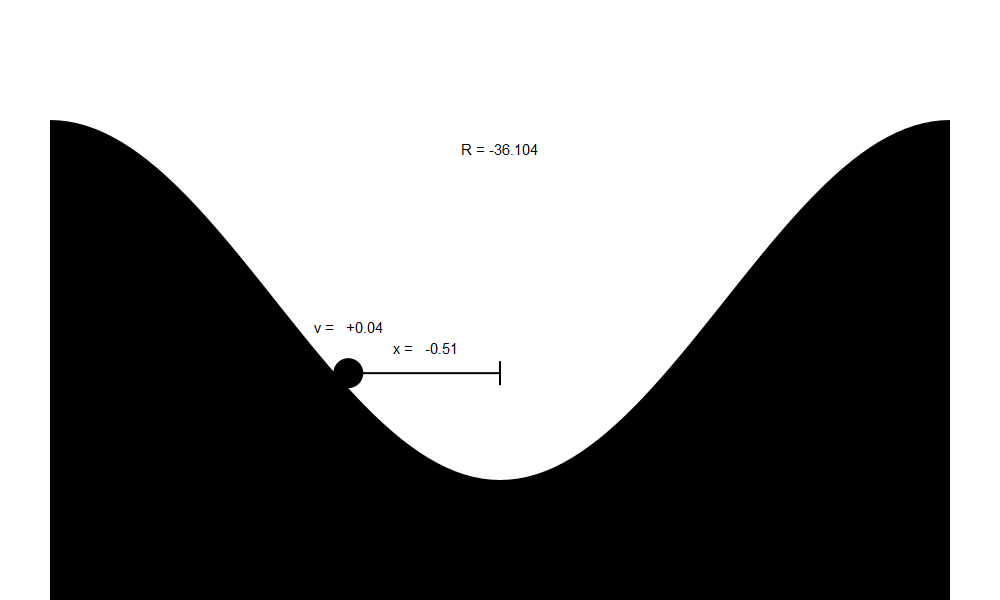
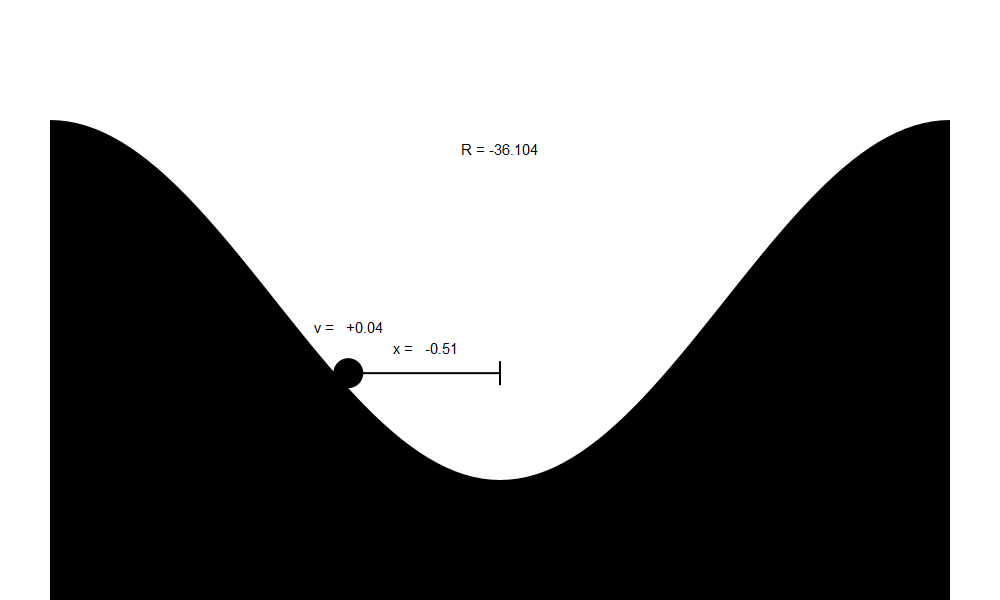

In [22]:
γfilter = SimpleMovingAverager(0.5, γ)
car2 = MountainCar(0.0,0.0)
R2 = 0.0
function tick!(Δt=1/60)
    global car2
    o = observation(car2)
    observe!(γfilter, o)
    a = γfilter.x > 0.0 ? :right : :left
    car2 = AA120Q.update!(car2, a)
    global R2 = R2*0.99 + reward(car2, a)
    render_mountain_car(car2, render_pos_overlay=true, reward=R2)
end
animate(tick!, 0:0.1:20)